In [76]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(1)    # reproducible

In [350]:
# Hyper Parameters
#EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
#LR = 0.001              # learning rate

In [351]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(50),
    torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder("./cyclegan/results/brats2013_train/trainB", transform=mytransform)

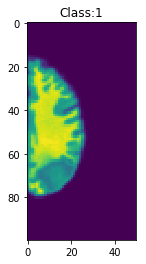

In [352]:
plt.imshow(data[500][0][0].numpy());
plt.title("Class:" + str(data[500][1]));

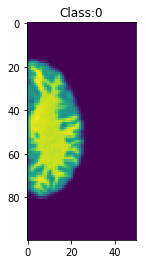

In [353]:
plt.imshow(data[0][0][0].numpy());
plt.title("Class:" + str(data[0][1]));

In [354]:
tosplit = np.asarray(data.imgs)[:,1]
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=0)

In [355]:
print "train_idx", len(train_idx)
print "valid_idx", len(valid_idx)

train_idx 455
valid_idx 152


In [356]:
#torch.utils.data.sampler.SubsetRandomSampler
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(dataset=data, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx))

In [357]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0])
valid_y = valid_data[0][1]

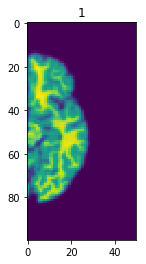

In [359]:
plt.imshow(valid_x[70][0].data.numpy());
plt.title(valid_y[70]);

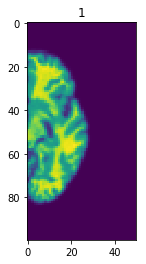

In [360]:
plt.imshow(valid_x[2][0].data.numpy());
plt.title(valid_y[2]);

In [361]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3,
                stride=1,   
                padding=0,        
            ),            
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=4,
                kernel_size=3,
                stride=1,   
                padding=0,        
            ),            
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=2,
                kernel_size=3,
                stride=1,   
                padding=0,        
            ),            
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(80, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [362]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d (3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d (8, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d (4, 2, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear(in_features=80, out_features=2)
)


In [363]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [366]:
for epoch in range(100):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
            
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        batch_loss.append(loss.data[0])
        
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid accuracy: %.2f' % accuracy)

('Epoch: ', 0, '| train loss: 0.5852', '| test accuracy: 0.66')
('Epoch: ', 1, '| train loss: 0.5795', '| test accuracy: 0.68')
('Epoch: ', 2, '| train loss: 0.5746', '| test accuracy: 0.69')
('Epoch: ', 3, '| train loss: 0.5473', '| test accuracy: 0.70')
('Epoch: ', 4, '| train loss: 0.5845', '| test accuracy: 0.67')
('Epoch: ', 5, '| train loss: 0.5881', '| test accuracy: 0.71')
('Epoch: ', 6, '| train loss: 0.5572', '| test accuracy: 0.72')
('Epoch: ', 7, '| train loss: 0.5363', '| test accuracy: 0.74')
('Epoch: ', 8, '| train loss: 0.5593', '| test accuracy: 0.73')
('Epoch: ', 9, '| train loss: 0.5574', '| test accuracy: 0.75')
('Epoch: ', 10, '| train loss: 0.5337', '| test accuracy: 0.75')
('Epoch: ', 11, '| train loss: 0.5246', '| test accuracy: 0.74')
('Epoch: ', 12, '| train loss: 0.5058', '| test accuracy: 0.74')
('Epoch: ', 13, '| train loss: 0.5398', '| test accuracy: 0.74')
('Epoch: ', 14, '| train loss: 0.5095', '| test accuracy: 0.74')
('Epoch: ', 15, '| train loss: 0.52

KeyboardInterrupt: 

In [404]:
import collections

In [ ]:
for percent in ["0.0", 
                "0.1", 
                "0.2", 
                "0.3", 
                "0.4", 
                "0.5", 
                "0.6", 
                "0.7", 
                "0.8", 
                "0.9", 
                "1.0"]:
    
    path = "./cyclegan/results/brats2013_cyclegan_" + percent + "/test_latest/"
    test_data_raw = torchvision.datasets.ImageFolder(path, transform=mytransform)
    test_loader = torch.utils.data.DataLoader(dataset=test_data_raw, batch_size=len(test_data_raw))

    test_data = list(test_loader)
    test_x = Variable(test_data[0][0])
    test_y = test_data[0][1]

    r = cnn(test_x)

    pred_y = torch.max(r[0], 1)[1].data.squeeze()

    print "Percent:", percent," Acc:", pred_y.numpy().mean(), " ", collections.Counter(pred_y)

Percent: 0.0  Acc: 0.650055370986   Counter({1: 1174, 0: 632})
Percent: 0.1  Acc: 0.661683277962   Counter({1: 1195, 0: 611})
Percent: 0.2  Acc: 0.678848283499   Counter({1: 1226, 0: 580})
Percent: 0.3  Acc: 0.706533776301   Counter({1: 1276, 0: 530})
Percent: 0.4  Acc: 0.710409745293   Counter({1: 1283, 0: 523})
